In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, KBinsDiscretizer, OneHotEncoder
from datetime import datetime
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from collections import Counter 
from sklearn.metrics import confusion_matrix, fbeta_score, classification_report
from sklearn.ensemble import VotingClassifier
import time
from mlxtend.frequent_patterns import apriori, association_rules
import joblib
import warnings
warnings.filterwarnings("ignore")
input_file = "E:/OVGU/Semester 3/DBSE Project/archive/fraudTrain.csv"
input_file1 = "E:/OVGU/Semester 3/DBSE Project/archive/fraudTest.csv"
train_csv = pd.read_csv(input_file, parse_dates=['trans_date_trans_time'])
test_csv = pd.read_csv(input_file1, parse_dates = ['trans_date_trans_time'])

In [2]:
train_csv.head(5)
test_csv.head(5)
#df.columns
#df.loc[df.is_fraud == 0,'merchant'].value_counts()
#df.merchant.unique()
#df.category.unique()
#df.city_pop.unique()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [3]:
#Data Cleaning - Checking for missing values and duplicate values

train_csv=train_csv.replace('',np.nan)
test_csv = test_csv.replace('', np.nan)
train_csv.isnull().sum(), test_csv.isnull().sum()

(Unnamed: 0               0
 trans_date_trans_time    0
 cc_num                   0
 merchant                 0
 category                 0
 amt                      0
 first                    0
 last                     0
 gender                   0
 street                   0
 city                     0
 state                    0
 zip                      0
 lat                      0
 long                     0
 city_pop                 0
 job                      0
 dob                      0
 trans_num                0
 unix_time                0
 merch_lat                0
 merch_long               0
 is_fraud                 0
 dtype: int64,
 Unnamed: 0               0
 trans_date_trans_time    0
 cc_num                   0
 merchant                 0
 category                 0
 amt                      0
 first                    0
 last                     0
 gender                   0
 street                   0
 city                     0
 state                    0
 zip 

In [4]:
train_csv.info(), test_csv.info()
#df.loc[df.is_fraud == 1,'category'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Unnamed: 0             1296675 non-null  int64         
 1   trans_date_trans_time  1296675 non-null  datetime64[ns]
 2   cc_num                 1296675 non-null  int64         
 3   merchant               1296675 non-null  object        
 4   category               1296675 non-null  object        
 5   amt                    1296675 non-null  float64       
 6   first                  1296675 non-null  object        
 7   last                   1296675 non-null  object        
 8   gender                 1296675 non-null  object        
 9   street                 1296675 non-null  object        
 10  city                   1296675 non-null  object        
 11  state                  1296675 non-null  object        
 12  zip                    12966

(None, None)

In [5]:
train_csv.duplicated().any(), test_csv.duplicated().any()

(False, False)

In [6]:
#Feature Extraction - Hour, HourEnc, 1D,7D,30D, Age, TimeDiff, age
train_csv['hour'] = train_csv.trans_date_trans_time.dt.hour
train_csv['hourEnc'] = 0
train_csv.loc[train_csv.hour < 5,'hourEnc'] = 1
train_csv.loc[train_csv.hour > 21,'hourEnc'] = 1

test_csv['hour'] = test_csv.trans_date_trans_time.dt.hour
test_csv['hourEnc'] = 0
test_csv.loc[test_csv.hour < 5,'hourEnc'] = 1
test_csv.loc[test_csv.hour > 21,'hourEnc'] = 1

In [7]:
def last1DayTransactionCount(x):
    temp = pd.Series(x.index, index = x.trans_date_trans_time, name='count_1_day').sort_index()
    count_1_day = temp.rolling('1d').count() - 1
    count_1_day.index = temp.values
    x['count_1_day'] = count_1_day.reindex(x.index)
    return x
def last7DaysTransactionCount(x):
    temp = pd.Series(x.index, index = x.trans_date_trans_time, name='count_7_days').sort_index()
    count_7_days = temp.rolling('7d').count() - 1
    count_7_days.index = temp.values
    x['count_7_days'] = count_7_days.reindex(x.index)
    return x
def last30DaysTransactionCount(x):
    temp = pd.Series(x.index, index = x.trans_date_trans_time, name='count_30_days').sort_index()
    count_30_days = temp.rolling('30d').count() - 1
    count_30_days.index = temp.values
    x['count_30_days'] = count_30_days.reindex(x.index)
    return x
train_csv1 = train_csv.groupby('cc_num', group_keys=False).apply(last1DayTransactionCount)
train_csv1 = train_csv1.groupby('cc_num', group_keys=False).apply(last7DaysTransactionCount)
train_csv1 = train_csv1.groupby('cc_num', group_keys=False).apply(last30DaysTransactionCount)

test_csv1 = test_csv.groupby('cc_num', group_keys=False).apply(last1DayTransactionCount)
test_csv1 = test_csv1.groupby('cc_num', group_keys=False).apply(last7DaysTransactionCount)
test_csv1 = test_csv1.groupby('cc_num', group_keys=False).apply(last30DaysTransactionCount)

In [8]:
def timeDifference(x):
    x['time_diff'] = x.trans_date_trans_time - x.trans_date_trans_time.shift()
    return x
train_csv1 = train_csv1.groupby('cc_num', group_keys=False).apply(timeDifference)
train_csv1['time_diff'] = train_csv1['time_diff'].dt.seconds
train_csv1=train_csv1.fillna(0)

test_csv1 = test_csv1.groupby('cc_num', group_keys=False).apply(timeDifference)
test_csv1['time_diff'] = test_csv1['time_diff'].dt.seconds
test_csv1=test_csv1.fillna(0)
train_csv1['time_diff'], test_csv1['time_diff']

(0              0.0
 1              0.0
 2              0.0
 3              0.0
 4              0.0
             ...   
 1296670    16781.0
 1296671     7962.0
 1296672    29074.0
 1296673     4618.0
 1296674    44250.0
 Name: time_diff, Length: 1296675, dtype: float64,
 0             0.0
 1             0.0
 2             0.0
 3             0.0
 4             0.0
            ...   
 555714    16630.0
 555715     9743.0
 555716      724.0
 555717    12025.0
 555718     7136.0
 Name: time_diff, Length: 555719, dtype: float64)

In [9]:
train_csv1['dob'] = pd.to_datetime(train_csv1['dob'])

train_csv1['age'] = np.round((train_csv1['trans_date_trans_time'] - train_csv1['dob'])/np.timedelta64(1, 'Y'))

test_csv1['dob'] = pd.to_datetime(test_csv1['dob'])

test_csv1['age'] = np.round((test_csv1['trans_date_trans_time'] - test_csv1['dob'])/np.timedelta64(1, 'Y'))

In [10]:
#dropping irrelevant features
train_csv1= train_csv1.drop(['Unnamed: 0', 'trans_date_trans_time','cc_num','merchant', 'first', 'last', 'street','city','state','job','dob','trans_num','unix_time', 'merch_lat','merch_long','lat','long','zip','city_pop'], axis = 1)
test_csv1= test_csv1.drop(['Unnamed: 0', 'trans_date_trans_time','cc_num','merchant', 'first', 'last', 'street','city','state','job','dob','trans_num','unix_time', 'merch_lat','merch_long', 'lat','long','zip','city_pop'], axis = 1)

In [11]:

continuous_features = ['amt', 'age', 'hour', 'hourEnc', 'count_1_day', 'count_7_days','count_30_days', 'time_diff']

# Determine the number of bins for each feature using Sturges' rule
num_bins = {}
for feature in continuous_features:
    n = train_csv1[feature].shape[0]
    num_bins[feature] = int(np.ceil(np.log2(n) + 1))

# Perform binning on the continuous-valued features with determined number of bins
binned_data = {}
binned_data_test = {}
for feature in continuous_features:
    binning_model = KBinsDiscretizer(n_bins=num_bins[feature], encode='ordinal', strategy='uniform')
    binned_data[feature] = binning_model.fit_transform(train_csv1[[feature]])
    binned_data_test[feature] = binning_model.transform(test_csv1[[feature]])
    

# Perform one-hot encoding on the binned data
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(pd.DataFrame(np.concatenate(list(binned_data.values()), axis=1)))
encoded_data_test = encoder.transform(pd.DataFrame(np.concatenate(list(binned_data_test.values()), axis=1)))


# Convert the encoded data to a DataFrame
encoded_data_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(list(num_bins.keys())))
encoded_data_test_df = pd.DataFrame(encoded_data_test, columns=encoder.get_feature_names_out(list(num_bins.keys())))

# Concatenate the encoded data with the original data
train_csv1 = pd.concat([train_csv1, encoded_data_df], axis=1)
test_csv1 = pd.concat([test_csv1, encoded_data_test_df], axis=1)



In [12]:
"""
continuous_features = ['amt', 'age', 'hour', 'hourEnc', 'count_1_day', 'count_7_days','count_30_days', 'time_diff']

# Determine the number of bins for each feature using Sturges' rule
num_bins = {}
for feature in continuous_features:
    n = test_csv1[feature].shape[0]
    num_bins[feature] = int(np.ceil(np.log2(n) + 1))

# Perform binning on the continuous-valued features with determined number of bins
binned_data = {}
for feature in continuous_features:
    binning_model = KBinsDiscretizer(n_bins=num_bins[feature], encode='ordinal', strategy='uniform')
    binned_data[feature] = binning_model.fit_transform(test_csv1[[feature]])

# Perform one-hot encoding on the binned data
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(pd.DataFrame(np.concatenate(list(binned_data.values()), axis=1)))

# Convert the encoded data to a DataFrame
encoded_data_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(list(num_bins.keys())))

# Concatenate the encoded data with the original data
test_csv1 = pd.concat([test_csv1, encoded_data_df], axis=1)

"""

"\ncontinuous_features = ['amt', 'age', 'hour', 'hourEnc', 'count_1_day', 'count_7_days','count_30_days', 'time_diff']\n\n# Determine the number of bins for each feature using Sturges' rule\nnum_bins = {}\nfor feature in continuous_features:\n    n = test_csv1[feature].shape[0]\n    num_bins[feature] = int(np.ceil(np.log2(n) + 1))\n\n# Perform binning on the continuous-valued features with determined number of bins\nbinned_data = {}\nfor feature in continuous_features:\n    binning_model = KBinsDiscretizer(n_bins=num_bins[feature], encode='ordinal', strategy='uniform')\n    binned_data[feature] = binning_model.fit_transform(test_csv1[[feature]])\n\n# Perform one-hot encoding on the binned data\nencoder = OneHotEncoder(sparse=False, handle_unknown='ignore')\nencoded_data = encoder.fit_transform(pd.DataFrame(np.concatenate(list(binned_data.values()), axis=1)))\n\n# Convert the encoded data to a DataFrame\nencoded_data_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(

In [13]:
encode_cols = ['category', 'gender']
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(train_csv1[encode_cols].values)
encoded_data_test = encoder.transform(test_csv1[encode_cols].values)
# Convert the encoded data to a DataFrame
encoded_data_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(encode_cols))
encoded_data_test_df = pd.DataFrame(encoded_data_test, columns=encoder.get_feature_names_out(encode_cols))

# Concatenate the encoded data with the original data
train_csv1 = pd.concat([train_csv1, encoded_data_df], axis=1)
test_csv1 = pd.concat([test_csv1, encoded_data_test_df], axis=1)

In [14]:
"""encode_cols = ['category', 'gender']
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(test_csv1[encode_cols].values)

# Convert the encoded data to a DataFrame
encoded_data_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(encode_cols))

# Concatenate the encoded data with the original data
test_csv1 = pd.concat([test_csv1, encoded_data_df], axis=1)"""

"encode_cols = ['category', 'gender']\nencoder = OneHotEncoder(sparse=False, handle_unknown='ignore')\nencoded_data = encoder.fit_transform(test_csv1[encode_cols].values)\n\n# Convert the encoded data to a DataFrame\nencoded_data_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(encode_cols))\n\n# Concatenate the encoded data with the original data\ntest_csv1 = pd.concat([test_csv1, encoded_data_df], axis=1)"

In [15]:
train_csv1.head(5), test_csv1.head(5)

(        category     amt gender  is_fraud  hour  hourEnc  count_1_day  \
 0       misc_net    4.97      F         0     0        1          0.0   
 1    grocery_pos  107.23      F         0     0        1          0.0   
 2  entertainment  220.11      M         0     0        1          0.0   
 3  gas_transport   45.00      M         0     0        1          0.0   
 4       misc_pos   41.96      M         0     0        1          0.0   
 
    count_7_days  count_30_days  time_diff  ...  category_home  \
 0           0.0            0.0        0.0  ...            0.0   
 1           0.0            0.0        0.0  ...            0.0   
 2           0.0            0.0        0.0  ...            0.0   
 3           0.0            0.0        0.0  ...            0.0   
 4           0.0            0.0        0.0  ...            0.0   
 
    category_kids_pets  category_misc_net  category_misc_pos  \
 0                 0.0                1.0                0.0   
 1                 0.0      

In [16]:
train_csv1 = train_csv1.drop(['category','amt','age','gender','hour','hourEnc','count_1_day','count_7_days','count_30_days','time_diff'], axis = 1)
test_csv1 = test_csv1.drop(['category','amt','age','gender','hour','hourEnc','count_1_day','count_7_days','count_30_days','time_diff'], axis = 1)


In [17]:
train_csv1.nunique()
#train_csv1['age'].min()

is_fraud                 2
amt_0.0                  2
amt_1.0                  2
amt_2.0                  2
amt_3.0                  2
                        ..
category_shopping_net    2
category_shopping_pos    2
category_travel          2
gender_F                 2
gender_M                 2
Length: 167, dtype: int64

In [18]:
#splitting features and target variable
x_train_original = train_csv1.drop(['is_fraud'], axis = 1).astype(np.float32)
y_train = train_csv1['is_fraud'].astype(np.float32)
x_train = x_train_original.copy() #making a copy and keeping the original as it is

x_test = test_csv1.drop(['is_fraud'], axis = 1).astype(np.float32)
y_test = test_csv1['is_fraud'].astype(np.float32)
#train_csv1.value_counts() #counting number of fraud(1) and normal (0) transactions

In [19]:
x_train = x_train[y_train==0].astype(np.float32) #train with only majority class(considering only class '0')

In [20]:
#training the model with default parameters and nu =0.006(0.6% of anomolous data)
start_time = time.time()
one_class_svm = OneClassSVM(nu=0.006, kernel = 'rbf', gamma = 'auto').fit(x_train)
end_time = time.time()
print("Training OneClassSVM time in minutes:", (end_time-start_time)/60)

Training OneClassSVM time in minutes: 161.56001044511794


In [21]:
joblib.dump(one_class_svm, 'oneclasssvm_model1.pkl') #saving the model

['oneclasssvm_model1.pkl']

In [22]:
#one_class_svm = joblib.load('oneclasssvm_model.pkl') #loading the model

In [23]:

prediction = one_class_svm.predict(x_test)

prediction = [1 if i==-1 else 0 for i in prediction]
# Check the model performance
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))
print("F2_Score", fbeta_score(y_test, prediction, beta=2))

[[547112   6462]
 [  2115     30]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    553574
         1.0       0.00      0.01      0.01      2145

    accuracy                           0.98    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      0.98      0.99    555719

F2_Score 0.009952229299363057


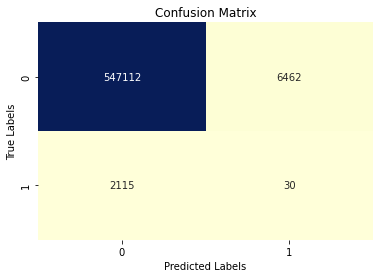

In [24]:
cm = confusion_matrix(y_test, prediction)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

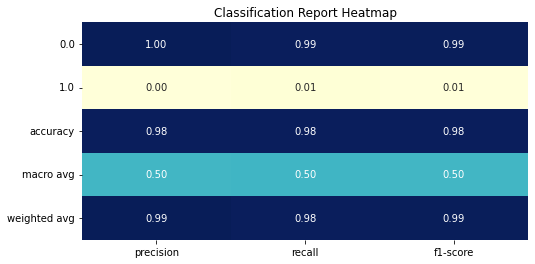

In [25]:
report = classification_report(y_test, prediction, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Remove the support column
report_df.drop("support", axis=1, inplace=True)

# Convert the classification report DataFrame to numeric values
report_df = report_df.apply(pd.to_numeric)

# Create a heatmap of the classification report
plt.figure(figsize=(8, 4))
sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt=".2f", cbar=False)
plt.title("Classification Report Heatmap")
plt.show()

In [26]:
#predicting with custom threshold. when we use predict(), it takes default threshold value and considers below threshold value as anomaly
#so, we use a score sample to set a customized thershold(need to tune it in order to have less false positives and less false negatives)
#tried 1%, 1.5%, 2%, 3% 
"""score = one_class_svm.score_samples(X_test_scaled)

score_threshold = np.percentile(score, 1.5)
print(f'The customized score threshold for 1.5% of outliers is {score_threshold:.2f}')

customized_prediction = [1 if i < score_threshold else 0 for i in score]
print(confusion_matrix(y_test, customized_prediction))
print(classification_report(y_test, customized_prediction))
print("F2_Score", fbeta_score(y_test, customized_prediction, beta=2))"""

'score = one_class_svm.score_samples(X_test_scaled)\n\nscore_threshold = np.percentile(score, 1.5)\nprint(f\'The customized score threshold for 1.5% of outliers is {score_threshold:.2f}\')\n\ncustomized_prediction = [1 if i < score_threshold else 0 for i in score]\nprint(confusion_matrix(y_test, customized_prediction))\nprint(classification_report(y_test, customized_prediction))\nprint("F2_Score", fbeta_score(y_test, customized_prediction, beta=2))'

In [27]:
frequent_itemsets_original = apriori(x_train_original, min_support=0.1, use_colnames=True)
rules_original = association_rules(frequent_itemsets_original, metric="confidence", min_threshold=0.7)

"""#Evaluating the association rules
rules_original['support'] = rules_original['support']
rules_original['confidence'] = rules_original['confidence']
rules_original['lift'] = rules_original['lift']
rules_original['conviction'] = rules_original['conviction']
rules_original['leverage'] = rules_original['leverage']
rules_original['interest'] = rules_original['leverage'] / rules_original['support']

print("original training data's rule mining metrics:")
print(rules_original[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'conviction', 'leverage', 'interest']])"""

rules_original.to_csv('rules_original.csv', index=False)

In [28]:
normal_instances = x_test[prediction == 0]
frequent_itemsets_normalpred = apriori(normal_instances, min_support=0.1, use_colnames=True)
rules_normalpred = association_rules(frequent_itemsets_normalpred, metric="confidence", min_threshold=0.7)

"""#Evaluating the association rules
rules_normalpred['support'] = rules_normalpred['support']
rules_normalpred['confidence'] = rules_normalpred['confidence']
rules_normalpred['lift'] = rules_normalpred['lift']
rules_normalpred['conviction'] = rules_normalpred['conviction']
rules_normalpred['leverage'] = rules_normalpred['leverage']
rules_normalpred['interest'] = rules_normalpred['leverage'] / rules_normalpred['support']

print("original training data's rule mining metrics:")
print(rules_normalpred[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'conviction', 'leverage', 'interest']])"""

rules_normalpred.to_csv('rules_normalpred.csv', index=False)

KeyError: False

In [ ]:
anomalous_instances = x_test[prediction == 1]
frequent_itemsets_anomalouspred = apriori(anomalous_instances, min_support=0.1, use_colnames=True)
rules_anomalouspred = association_rules(frequent_itemsets_anomalouspred, metric="confidence", min_threshold=0.7)

"""#Evaluating the association rules
rules_anomalouspred['support'] = rules_anomalouspred['support']
rules_anomalouspred['confidence'] = rules_anomalouspred['confidence']
rules_anomalouspred['lift'] = rules_anomalouspred['lift']
rules_anomalouspred['conviction'] = rules_anomalouspred['conviction']
rules_anomalouspred['leverage'] = rules_anomalouspred['leverage']
rules_anomalouspred['interest'] = rules_anomalouspred['leverage'] / rules_anomalouspred['support']

print("original training data's rule mining metrics:")
print(rules_anomalouspred[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'conviction', 'leverage', 'interest']])"""

rules_anomalouspred.to_csv('rules_anomalouspred.csv', index=False)